In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.model_selection import train_test_split


from SARIMAX import *
%load_ext autoreload
%autoreload 2

In [2]:
# Set file path and parameters
file_path = "/Users/alonclausen/Desktop/Studie/Kandidat/Seminar/SEMINARFIN/fulldata.csv"

In [3]:

loader = DataLoader(file_path, 
                    use_temp_pca=True, 
                    use_wind_pca=True, 
                    use_fourier=True, 
                    use_oil=True, 
                    use_gas=True)

loader.load_data()
spot_price, exog_data = loader.preprocess_data()

In [4]:
# Step 2: Standardize Exogenous Features for LASSO
if not exog_data.empty:
    scaler = StandardScaler()
    exog_scaled = scaler.fit_transform(exog_data)
else:
    exog_scaled = None
    print("No exogenous variables selected. Skipping scaling step.")


In [5]:
# Step 3: Fit LASSO Regression
print("Fitting LASSO regression for feature selection...")
lasso = LassoCV(cv=5, max_iter=5000)  # Cross-validation to find the best alpha
lasso.fit(exog_scaled, spot_price)

Fitting LASSO regression for feature selection...


LassoCV(cv=5, max_iter=5000)

In [6]:
# Step 4: Extract Selected Features
selected_features = exog_data.columns[lasso.coef_ != 0]
print("Selected Features:", selected_features)

# Reduce exogenous data to selected features
exog_selected = exog_data[selected_features]

Selected Features: Index(['temp_pca_1', 'temp_pca_2', 'temp_pca_3', 'wind_speed_pca_1',
       'wind_speed_pca_2', 'wind_speed_pca_3', 'wind_speed_pca_4',
       'wind_speed_pca_5', 'wind_speed_pca_6', 'wind_speed_pca_7',
       'wind_speed_pca_8', 'wind_speed_pca_9', 'wind_speed_pca_10',
       'wind_speed_pca_11', 'wind_speed_pca_12', 'wind_speed_pca_13',
       'wind_speed_pca_14', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'month_sin', 'month_cos', 'oil_price', 'gas_price'],
      dtype='object')


In [7]:
# Define the date range for training
train_start = '2017-10-27'
train_end = '2024-07-31'

# Filter the spot_price and exog_selected based on the date range
train_data = spot_price.loc[train_start:train_end]
#train_exog = exog_selected.loc[train_start:train_end]

# Confirm the shape of the data
print("Training data shape:", train_data.shape)
#print("Training exogenous features shape:", train_exog.shape)


Training data shape: (59280,)


In [8]:


# Define the date range for training
#train_start = '2023-10-27'
#train_end = '2024-07-31'

# Filter the spot_price and exog_features based on the date range
#train_data = spot_price.loc[train_start:train_end]
#train_exog = exog_selected.loc[train_start:train_end]

# Split into train and test (optional)
#train_y, test_y = train_test_split(train_data, test_size=0.1)


# Define exogenous variables and ensure alignment with the target variable
#exog_features = exog_data.loc[train_data.index]

# Run auto_arima with exogenous variables
#auto_model = pm.auto_arima(
#    train_data,                 # Target variable (spot_price)
#    exogenous=exog_features,    # Exogenous predictors
#    seasonal=True,              # Allows seasonal terms
#    m=12,                       # Seasonality frequency (12 for monthly, 24 for daily hours)
#    stepwise=True,              # Stepwise search for efficiency
#    trace=True,                 # Print progress
#    suppress_warnings=True,     # Ignore warnings
#    error_action='ignore',      # Ignore invalid models
#    max_order=(5, 2)            # Limit AR, MA, and seasonal orders for faster search
#)

# Print the best model summary
#print(auto_model.summary())



In [9]:
# After auto_arima is done
#order = (5,1,0)       # (p, d, q)
#seasonal_order = (2,0,0,12)  # (P, D, Q, m)

# Create SARIMAWrapper instance with the discovered orders
#model = SARIMAWrapper(order=order, seasonal_order=seasonal_order)

# Fit the model on your training data and exogenous features
# Make sure exog_features matches the training set index and includes selected features
#train_exog = exog_selected.loc[train_data.index]
#model.fit(train_data, train_exog)

In [10]:
# Save the fitted results to a file
#model.results.save('fitted_model.pkl')


In [11]:
#Find the latest day in entire dataset
latest_day = spot_price.index[-1]
print(latest_day)



2024-11-29 23:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# Load the previously saved fitted results (the model)
loaded_results = SARIMAXResults.load('fitted_model.pkl')

# Define the forecast start and end
forecast_start = pd.Timestamp('2024-08-01 00:00:00')
forecast_end = pd.Timestamp('2024-11-29 23:00:00')  # Shorter period for demonstration

# Create a daily index for the days we want to forecast
daily_forecast_start_times = pd.date_range(start=forecast_start, end=forecast_end, freq='D', inclusive='left')

# Assume you have your main series and exogenous data:
# spot_price: the full historical and future-known actuals of the target variable
# exog_selected: the selected exogenous features used in the model

# actual_data includes actual values over the entire period (for demonstration)
actual_data = spot_price.loc[:forecast_end]

# Ensure exogenous data coverage for the full test period + 24 hours before
full_exog_index = pd.date_range(start=forecast_start - pd.Timedelta(hours=24),
                                end=forecast_end, freq='h')
exog_features_reduced = exog_selected.reindex(full_exog_index).ffill()

# Extract original exogenous columns from the loaded model
orig_exog_columns = loaded_results.model.data.orig_exog.columns

all_forecasts = []
last_model_time = loaded_results.model.data.orig_endog.index[-1]

for start_time in daily_forecast_start_times:
    # We'll forecast 24 hours from start_time
    end_time = start_time + pd.Timedelta(hours=23)

    # If the end_time exceeds forecast_end, stop
    if end_time > forecast_end:
        break

    # Data known up to 24 hours before the forecast day starts
    # For example, if start_time is Day 3 00:00, we only have data until Day 1 24:00 (Day 2 00:00)
    # This means data_end_time = start_time - 24 hours
    data_end_time = start_time - pd.Timedelta(hours=24)

    # Append newly available actual data if any
    if data_end_time > last_model_time:
        new_data = actual_data.loc[(last_model_time + pd.Timedelta(hours=1)):data_end_time]
        if not new_data.empty:
            new_exog = exog_features_reduced.loc[new_data.index, orig_exog_columns]
            loaded_results = loaded_results.append(new_data, exog=new_exog, refit=False)
            last_model_time = data_end_time

    # Now forecast for the next 24 hours
    forecast_index = pd.date_range(start=start_time, periods=24, freq='h')

    # For each forecast hour, we use exogenous data from exactly 24 hours before that hour
    forecast_exog_list = []
    for fc_time in forecast_index:
        past_time = fc_time - pd.Timedelta(hours=24)
        if past_time not in exog_features_reduced.index:
            raise ValueError(f"No exog data available for {past_time}")
        forecast_exog_list.append(exog_features_reduced.loc[past_time, orig_exog_columns].values)

    forecast_exog_df = pd.DataFrame(forecast_exog_list, index=forecast_index, columns=orig_exog_columns)

    # Get a 24-step forecast
    forecast_result = loaded_results.get_forecast(steps=24, exog=forecast_exog_df)
    day_forecasts = forecast_result.predicted_mean
    all_forecasts.append(day_forecasts)

# Combine all daily forecasts
forecasts = pd.concat(all_forecasts)

# If you have actuals to evaluate
actuals = spot_price.loc[forecasts.index]
common_index = actuals.index.intersection(forecasts.index)

if not common_index.empty:
    mae = mean_absolute_error(actuals.loc[common_index], forecasts.loc[common_index])
    mse = mean_squared_error(actuals.loc[common_index], forecasts.loc[common_index])
    rmse = np.sqrt(mse)
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")
else:
    print("No overlapping actual data to evaluate.")

# Optionally save forecasts
forecast_array = forecasts.values
np.save('forecast_max.npy', forecast_array)


/var/folders/jg/p6c6lqr91kj2q41htjb2tvsc0000gn/T/ipykernel_7828/1776208974.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_exog_index = pd.date_range(start=forecast_start - pd.Timedelta(hours=24),
/var/folders/jg/p6c6lqr91kj2q41htjb2tvsc0000gn/T/ipykernel_7828/1776208974.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=start_time, periods=24, freq='H')
/var/folders/jg/p6c6lqr91kj2q41htjb2tvsc0000gn/T/ipykernel_7828/1776208974.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=start_time, periods=24, freq='H')
/var/folders/jg/p6c6lqr91kj2q41htjb2tvsc0000gn/T/ipykernel_7828/1776208974.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=start_time, pe

MAE: 189.2928, RMSE: 274.1371


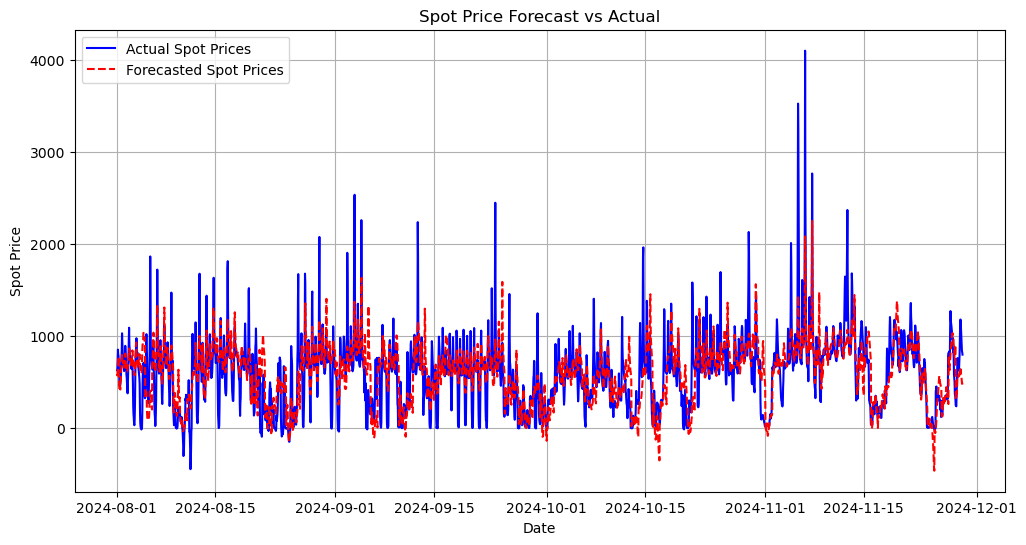

In [32]:
import matplotlib.pyplot as plt

# Ensure actuals and forecasts are aligned over the forecast horizon
common_index = forecasts.index.intersection(actuals.index)
plot_actuals = actuals.loc[common_index]
plot_forecasts = forecasts.loc[common_index]

plt.figure(figsize=(12, 6))
plt.plot(actuals.index, plot_actuals.values, label='Actual Spot Prices', color='blue')
plt.plot(forecasts.index, plot_forecasts.values, label='Forecasted Spot Prices', color='red', linestyle='--')
plt.title('Spot Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Spot Price')
plt.legend()
plt.grid(True)
plt.show()


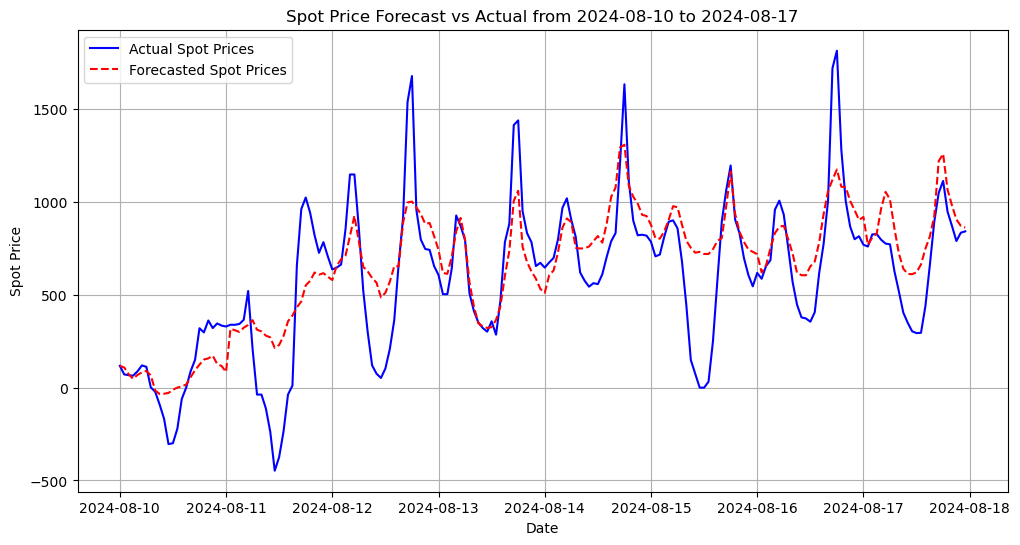

In [33]:
import matplotlib.pyplot as plt

# Specify the week you want to inspect
week_start = '2024-08-10'
week_end = '2024-08-17'

# Ensure the indexes are sorted
forecasts = forecasts.sort_index()
actuals = actuals.sort_index()

# Extract forecasts and actuals for that week
forecasts_for_week = forecasts.loc[week_start:week_end]
actuals_for_week = actuals.loc[week_start:week_end]

# # Find the common index to ensure alignment
# common_index = forecasts_for_week.index.intersection(actuals_for_week.index)
# forecasts_for_week = forecasts_for_week.loc[common_index]
# actuals_for_week = actuals_for_week.loc[common_index]

plt.figure(figsize=(12, 6))
plt.plot(actuals_for_week.index, actuals_for_week.values, label='Actual Spot Prices', color='blue')
plt.plot(forecasts_for_week.index, forecasts_for_week.values, label='Forecasted Spot Prices', color='red', linestyle='--')
plt.title(f'Spot Price Forecast vs Actual from {week_start} to {week_end}')
plt.xlabel('Date')
plt.ylabel('Spot Price')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Print the forecast with timestamps
for timestamp, value in forecasts.items():
    print(f"{timestamp}: {value}")

2024-08-01 01:00:00: 583.7679012002693
2024-08-01 01:00:00: 644.1591739848104
2024-08-01 02:00:00: 572.0479044002453
2024-08-01 02:00:00: 647.6968611532016
2024-08-01 03:00:00: 624.2663123497261
2024-08-01 03:00:00: 704.8294923772194
2024-08-01 04:00:00: 691.9923747837453
2024-08-01 04:00:00: 763.5968141322584
2024-08-01 05:00:00: 728.379473507935
2024-08-01 05:00:00: 807.3598216124401
2024-08-01 06:00:00: 776.0729302944642
2024-08-01 06:00:00: 683.3081970553429
2024-08-01 07:00:00: 577.7596530321
2024-08-01 07:00:00: 677.2830406614044
2024-08-01 08:00:00: 494.8356272336762
2024-08-01 08:00:00: 576.3222252883111
2024-08-01 09:00:00: 431.88257144499994
2024-08-01 09:00:00: 506.2014646710679
2024-08-01 10:00:00: 472.96794705831155
2024-08-01 10:00:00: 410.35680187212995
2024-08-01 11:00:00: 445.74771993996654
2024-08-01 11:00:00: 389.2323490823858
2024-08-01 12:00:00: 419.09381866867625
2024-08-01 12:00:00: 469.6611218509727
2024-08-01 13:00:00: 521.6454083095143
2024-08-01 13:00:00: 471

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure actuals and forecasts are aligned over the test period
common_index = actuals.index.intersection(forecasts.index)
test_actuals = actuals.loc[common_index]
test_forecasts = forecasts.loc[common_index]


# Calculate MAE and RMSE
mae_test = mean_absolute_error(test_actuals, test_forecasts)
rmse_test = np.sqrt(mean_squared_error(test_actuals, test_forecasts))

print(f"Test MAE: {mae_test:.4f}, Test RMSE: {rmse_test:.4f}")

Test MAE: 189.2928, Test RMSE: 274.1371


In [19]:
# Ensure actuals and forecasts are aligned over the test period
common_index = actuals.index.intersection(forecasts.index)
test_actuals = actuals.loc[common_index]
test_forecasts = forecasts.loc[common_index]

# Print the actual data
print("Actual Data:")
print(test_actuals.values)

# Print the forecasted data
print("Forecasted Data:")
print(test_forecasts.values)

Actual Data:
[627.640015 627.640015 642.48999  ... 839.809998 822.619995 798.090027]
Forecasted Data:
[583.7679012  644.15917398 572.0479044  ... 486.44055304 491.49795229
 446.09318822]


In [25]:
forecasts = forecasts[~forecasts.index.duplicated(keep='first')]
actuals = actuals[~actuals.index.duplicated(keep='first')]


In [26]:
common_index = actuals.index.intersection(forecasts.index)
print(forecasts.loc[common_index].head())
print(actuals.loc[common_index].head())


2024-08-01 01:00:00    583.767901
2024-08-01 02:00:00    572.047904
2024-08-01 03:00:00    624.266312
2024-08-01 04:00:00    691.992375
2024-08-01 05:00:00    728.379474
Name: predicted_mean, dtype: float64
2024-08-01 01:00:00    627.640015
2024-08-01 02:00:00    642.489990
2024-08-01 03:00:00    739.500000
2024-08-01 04:00:00    852.320007
2024-08-01 05:00:00    798.369995
Name: SpotPriceDKK, dtype: float64


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure actuals and forecasts are aligned over the test period
common_index = actuals.index.intersection(forecasts.index)
new_actuals = actuals.loc[common_index]
new_forecasts = forecasts.loc[common_index]

# Calculate MAE and RMSE
new_mae = mean_absolute_error(new_actuals, new_forecasts)
new_rmse = np.sqrt(mean_squared_error(new_actuals, new_forecasts))

print(f"New MAE: {new_mae:.4f}, New RMSE: {new_rmse:.4f}")

New MAE: 190.3452, New RMSE: 275.1599


In [28]:
# Save the forecast values as an npy file
np.save('SARIMAX_FORECASTEDREAL.npy', forecasts.values)

In [30]:
forecasts.to_csv('forecast_max.csv', header=True)

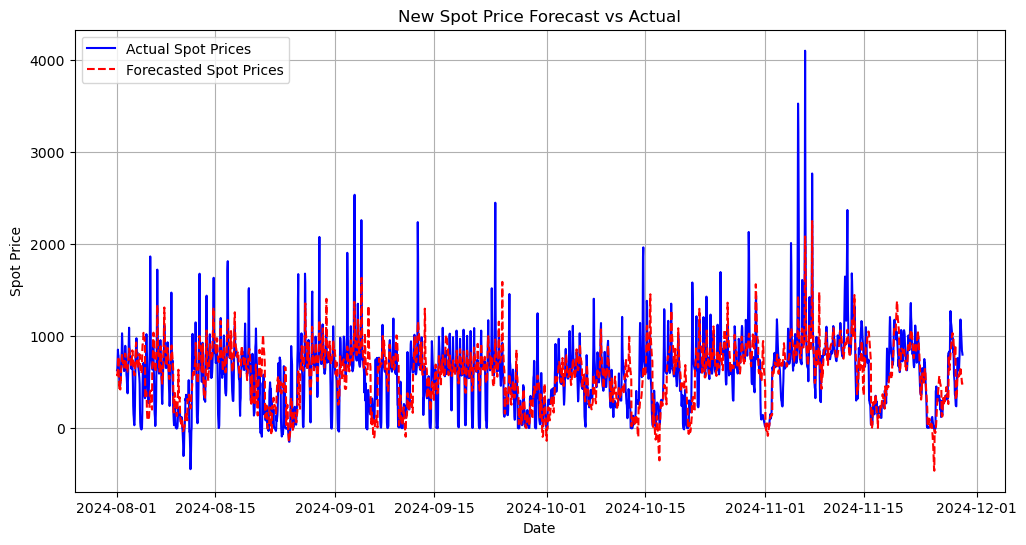

In [29]:
import matplotlib.pyplot as plt

# Ensure new_actuals and new_forecasts are aligned over the forecast horizon
common_index = new_actuals.index.intersection(new_forecasts.index)
plot_new_actuals = new_actuals.loc[common_index]
plot_new_forecasts = new_forecasts.loc[common_index]

plt.figure(figsize=(12, 6))
plt.plot(plot_new_actuals.index, plot_new_actuals.values, label='Actual Spot Prices', color='blue')
plt.plot(plot_new_forecasts.index, plot_new_forecasts.values, label='Forecasted Spot Prices', color='red', linestyle='--')
plt.title('New Spot Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Spot Price')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# create pandas df from forecasts 
df_forecasts = pd.DataFrame(forecasts)

# create a new df with all hours from start to end
all_hours = pd.date_range(start=min(df_forecasts.index), end=max(df_forecasts.index), freq='h')

all_hours = pd.DataFrame(all_hours)
df_forecasts

,predicted_mean
2024-08-01 01:00:00,583.767901
2024-08-01 02:00:00,572.047904
2024-08-01 03:00:00,624.266312
2024-08-01 04:00:00,691.992375
2024-08-01 05:00:00,728.379474
...,...
2024-11-28 20:00:00,550.944147
2024-11-28 21:00:00,534.219638
2024-11-28 22:00:00,486.440553
2024-11-28 23:00:00,491.497952
